In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score

import mlflow
from mlflow_utils import run_experiment

from utils.eval import (
    plot_confusion_matrix,
    display_confusion_matrices,
    print_metrics,
    create_and_log_roc_curves,
    find_best_threshold
)

import joblib

In [13]:
mlflow.set_tracking_uri("file:///C:/Users/Galyna/Documents/_______Machine%20Learning%20Course%202.0/_MidtermProject/mlruns")
print(mlflow.get_tracking_uri())

file:///C:/Users/Galyna/Documents/_______Machine%20Learning%20Course%202.0/_MidtermProject/mlruns


In [14]:
df = pd.read_csv("data/bank-additional-full.csv", sep=';')
df = df.drop_duplicates()
df['y'] = df['y'].map({'yes': 1, 'no': 0})
df.drop(columns=['duration'], inplace=True)
df['marital'] = df['marital'].replace('unknown', 'married') # Replace 'unknown' with 'married' (the most frequent value)
df['pdays'] = (df['pdays'] != 999).astype(int) 
df['campaign'] = pd.cut(df['campaign'], bins=[0, 1, 2, 3, 4, 5, 10, float('inf')], labels=['1', '2', '3', '4', '5', '6-10', '11+'], right=False)
df['age_squared'] = df['age'] ** 2
df['log_age'] = np.log(df['age'])

In [15]:
df.to_csv('data/preprocessed_bank_data.csv', index=False)

In [16]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['y'])

In [17]:
target_col = 'y'
input_cols = [col for col in train_df.columns if col != target_col]

# Extract features and targets
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

# Convert integer columns to float64 (for MLflow schema safety)
for df in [train_inputs, val_inputs]:
    int_cols = df.select_dtypes(include='int').columns
    df[int_cols] = df[int_cols].astype('float64')

In [18]:
joblib.dump(train_inputs, 'data/train_inputs.pkl')
joblib.dump(train_targets, 'data/train_targets.pkl')
joblib.dump(val_inputs, 'data/val_inputs.pkl')
joblib.dump(val_targets, 'data/val_targets.pkl')

['data/val_targets.pkl']

In [19]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()  
categorical_cols = train_inputs.select_dtypes(include=['object', 'category']).columns.tolist()

print(len(numeric_cols), numeric_cols)
print(len(categorical_cols), categorical_cols)  

10 ['age', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'age_squared', 'log_age']
11 ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'campaign', 'poutcome']


### Logistic Regression

Let's transform numeric columns and apply one-hot encoding to categorical ones.

In [20]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

In [21]:
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [22]:
mlflow.set_experiment("MidTerm Project Logistic Regression")
mlflow.set_experiment_tag("scikit-learn", "lr")

In [23]:
numeric_poly_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

In [24]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_poly_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

In [25]:
poly_logreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', class_weight='balanced'))
])

In [26]:
metrics, train_pred, val_pred, train_proba, val_proba = run_experiment(
                                poly_logreg,
                                train_inputs, train_targets,
                                val_inputs,   val_targets,
                                run_name="Poly LR (deg 2)",
                                registered_model_name="Poly_LogReg_deg2"
                                )

Registered model 'Poly_LogReg_deg2' already exists. Creating a new version of this model...
Created version '6' of model 'Poly_LogReg_deg2'.


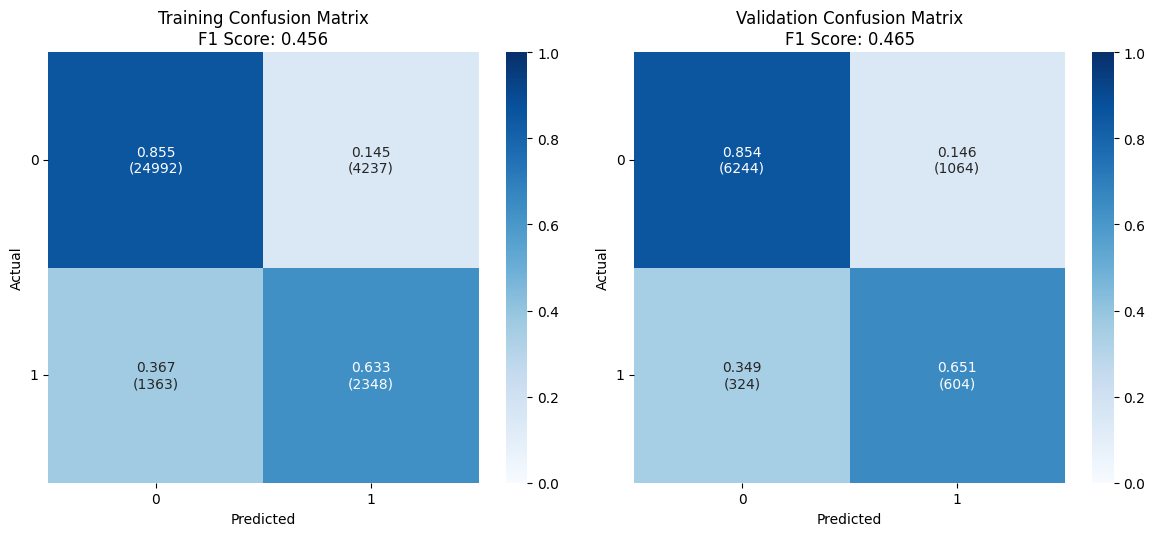

In [27]:
display_confusion_matrices(
    train_targets, train_pred,
    val_targets,   val_pred,
    cmap="Blues"   
)

In [28]:
print_metrics(train_targets, train_pred, val_targets, val_pred, train_proba, val_proba)

Train vs Validation

Metric            Train      Validation
----------------------------------------
F1 Score          0.456           0.465
Precision         0.357           0.362
Recall            0.633           0.651
Accuracy          0.830           0.831
ROC AUC           0.800           0.801


In [29]:
best_thresh, best_f1 = find_best_threshold(val_targets, val_proba, metric=f1_score)
print("Best threshhold on the validation dataset:", best_thresh)
print("Best F1 score:", best_f1)

Best threshhold on the validation dataset: 0.62
Best F1 score: 0.5107354956601188


### K-Nearest-Neighbours

In [30]:
# Set the experiment
mlflow.set_experiment("MidTerm Project K-Nearest Neighbours")
mlflow.set_experiment_tag("scikit-learn", "knn") 

# Define preprocessing and pipeline 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols),
    ]
)

knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=2, weights='distance', n_jobs=-1)) 
])

In [31]:
metrics, train_pred, val_pred, train_proba, val_proba = run_experiment(
    knn,
    train_inputs, train_targets,
    val_inputs,   val_targets,
    run_name="KNN (k=2)"
)

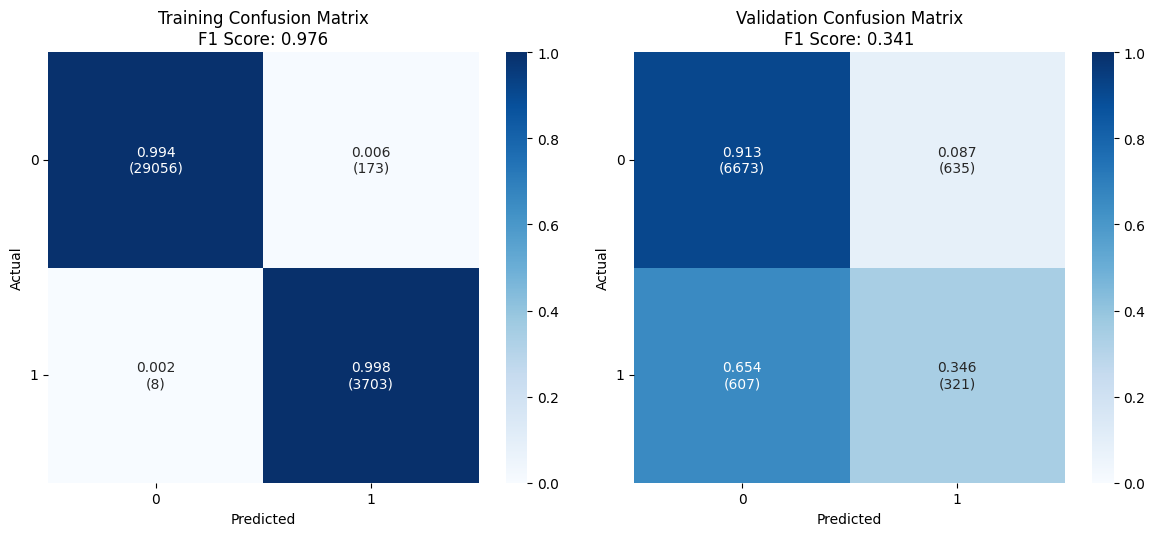

In [32]:
display_confusion_matrices(
    train_targets, train_pred,
    val_targets,   val_pred,
    cmap="Blues"   
)

In [33]:
print_metrics(train_targets, train_pred, val_targets, val_pred, train_proba, val_proba)

Train vs Validation

Metric            Train      Validation
----------------------------------------
F1 Score          0.976           0.341
Precision         0.955           0.336
Recall            0.998           0.346
Accuracy          0.995           0.849
ROC AUC           0.999           0.679


In [34]:
best_thresh, best_f1 = find_best_threshold(val_targets, val_proba, metric=f1_score)
print("Best threshhold on the validation dataset:", best_thresh)
print("Best F1 score:", best_f1)

Best threshhold on the validation dataset: 0.43
Best F1 score: 0.3769911504424779


### Decision Tree 

In [35]:
# Set the experiment
mlflow.set_experiment("MidTerm Project Decision Tree")
mlflow.set_experiment_tag("scikit-learn", "decision tree")

# Define preprocessing and pipeline 
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)

decision_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=5, max_leaf_nodes=26, class_weight='balanced', random_state=42)) 
])

In [36]:
metrics, train_pred, val_pred, train_proba, val_proba = run_experiment(
    decision_tree,
    train_inputs, train_targets,
    val_inputs,   val_targets,
    run_name="Decision Tree (max_depth=5, max_leaf_nodes=26)"
)

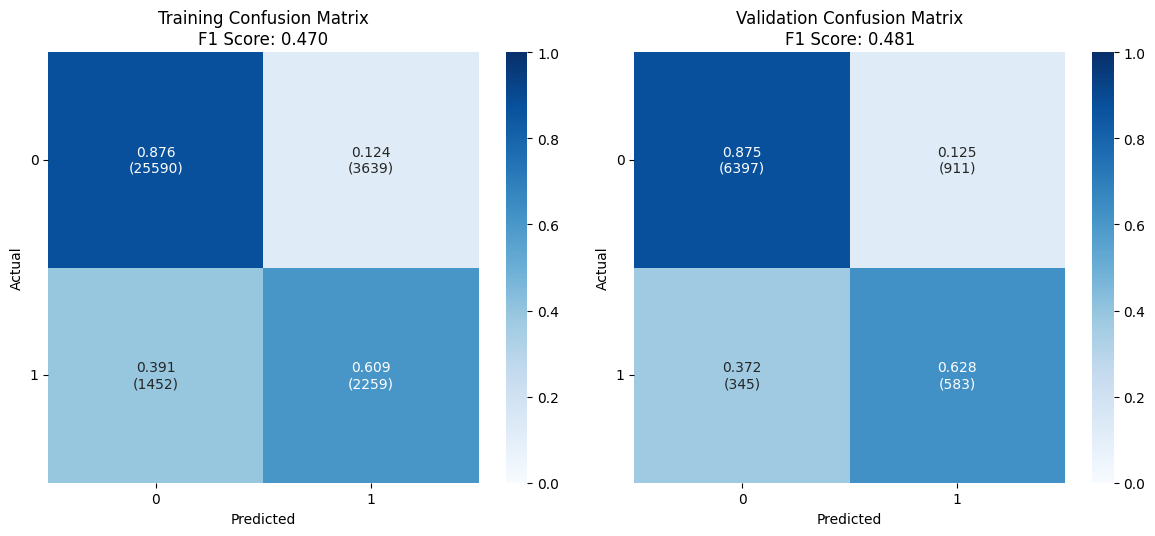

In [37]:
display_confusion_matrices(
    train_targets, train_pred,
    val_targets,   val_pred,
    cmap="Blues"   
)

In [38]:
print_metrics(train_targets, train_pred, val_targets, val_pred, train_proba, val_proba)

Train vs Validation

Metric            Train      Validation
----------------------------------------
F1 Score          0.470           0.481
Precision         0.383           0.390
Recall            0.609           0.628
Accuracy          0.845           0.847
ROC AUC           0.784           0.790


In [39]:
best_thresh, best_f1 = find_best_threshold(val_targets, val_proba, metric=f1_score)
print("Best threshhold on the validation dataset:", best_thresh)
print("Best F1 score:", best_f1)

Best threshhold on the validation dataset: 0.71
Best F1 score: 0.5030241935483871


### Random Forest

In [45]:
# Set the experiment
mlflow.set_experiment("MidTerm Project Random Forest")
mlflow.set_experiment_tag("scikit-learn", "random forest")

In [46]:
random_forest = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        class_weight='balanced',
        random_state=42
    ))
])

In [47]:
metrics, train_pred, val_pred, train_proba, val_proba = run_experiment(
    random_forest,
    train_inputs, train_targets,
    val_inputs,   val_targets,
    run_name="Random Forest (max_depth=10)"
)

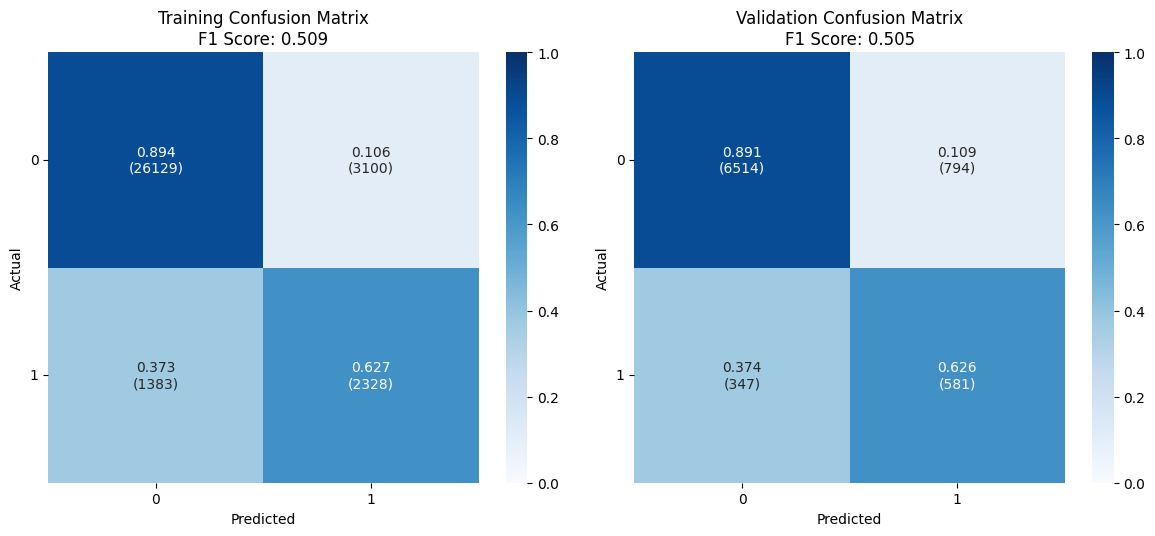

In [48]:
display_confusion_matrices(
    train_targets, train_pred,
    val_targets,   val_pred,
    cmap="Blues"   
)

In [49]:
best_thresh, best_f1 = find_best_threshold(val_targets, val_proba, metric=f1_score)
print("Best threshhold on the validation dataset:", best_thresh)
print("Best F1 score:", best_f1)

Best threshhold on the validation dataset: 0.62
Best F1 score: 0.5285433070866141


#### Let's look at the comparison of these models in MLFlow. 

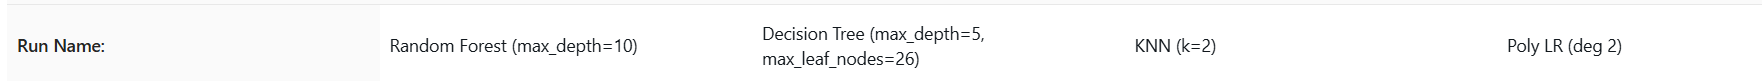

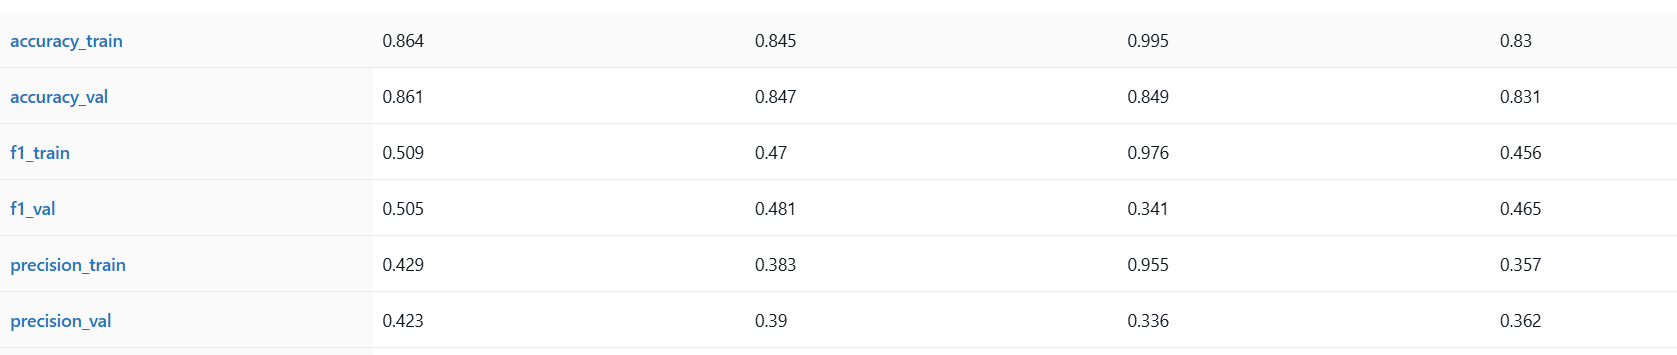

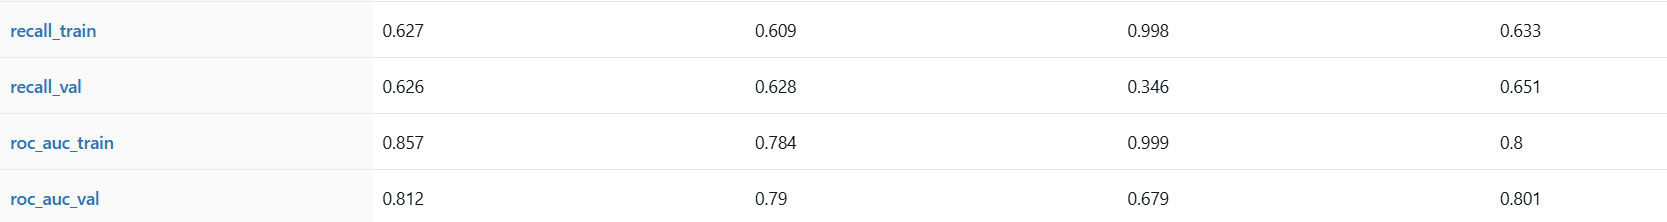

As we can see, the KNN model was overfitted — it performed extremely well on the training set but dropped significantly on the validation set, especially in F1 and ROC AUC. The Random Forest model had the highest F1 and ROC AUC scores and showed the best balance between training and validation, making it the most reliable choice.